In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
import sklearn
print(sklearn.__version__)
SEED = 42

0.24.1


In [2]:
def show_mostly_correlated(column, df):
    df_all_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
    return df_all_corr[df_all_corr['Feature 1'] == column]

def show_scatter_matrix(df, **kwargs):
    from pandas.plotting import scatter_matrix
    return scatter_matrix(df, **kwargs)

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def display_missing(df):
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print("\n")

In [3]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [4]:
X = pd.read_csv("/mnt/c/users/Fyodor/ml/kaggle/titanic/data/train.csv")
data_test = pd.read_csv("/mnt/c/users/Fyodor/ml/kaggle/titanic/data/test.csv")
data_all = concat_df(X, data_test)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/users/Fyodor/ml/kaggle/titanic/data/train.csv'

In [5]:
X.name = "Training set"
data_test.name = "Test set"
data_all.name = "All set"

dfs = [X, data_test]

In [6]:
print('Number of Training Examples = {}'.format(X.shape[0]))
print('Number of Test Examples = {}\n'.format(data_test.shape[0]))
print('Training X Shape = {} x {}'.format(*X.shape))
print('Training y Shape = {}\n'.format(X['Survived'].shape[0]))
print('Test X Shape = {} x {}'.format(*data_test.shape))
print('Test y Shape = {}\n'.format(data_test.shape[0]))
print(X.columns)
print(data_test.columns)

print(set(X.columns) - set(data_test.columns))

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = 891 x 12
Training y Shape = 891

Test X Shape = 418 x 11
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
{'Survived'}


# Exploratory data analysis

In [7]:
print(data_test.info())
X.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
53,54,1,2,"Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkin...",female,29.0,1,0,2926,26.0000,NaN,S
361,362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C


In [8]:
for df in dfs:
    print(f"{df.name}")
    display_missing(df)

Training set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [9]:
show_mostly_correlated("Age", data_all)
display_missing(data_all)

Age column missing values: 263
Cabin column missing values: 1014
Embarked column missing values: 2
Fare column missing values: 1
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 418
Ticket column missing values: 0




In [10]:
age_by_pclass_sex = data_all.groupby(['Sex', 'Pclass']).median()["Age"]
display(age_by_pclass_sex)

for pclass in range(1, 4):
    for sex in ("female", "male"):
        print(f"Median age of Pclass {pclass} {sex}s - {age_by_pclass_sex.loc[sex, pclass]}")
print(f"\nMedian age of all passengers - {data_all['Age'].median()}")

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

Median age of Pclass 1 females - 36.0
Median age of Pclass 1 males - 42.0
Median age of Pclass 2 females - 28.0
Median age of Pclass 2 males - 29.5
Median age of Pclass 3 females - 22.0
Median age of Pclass 3 males - 25.0

Median age of all passengers - 28.0


In [11]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
data_all['Age'] = data_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [12]:
data_all[data_all["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [13]:
# https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
data_all['Embarked'].fillna('S', inplace=True)

In [14]:
data_all[data_all["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [15]:
median_fare = data_all.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median().loc[3, 0, 0] # 3rd class 0 parch 0 SibSp
print(median_fare)
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
data_all["Fare"].fillna(median_fare, inplace=True)

7.8542


# Decks and cabins
![](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)

In [16]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
data_all["Deck"] = data_all["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = data_all.groupby(["Deck", "Pclass"]).count().drop(columns=["Survived", "Sex", "Age", "SibSp", "Parch",
                                                                         "Fare", "Embarked", "Cabin", "PassengerId",
                                                                         "Ticket"]).rename(columns={"Name": "Count"}).transpose()

display(df_all_decks)

def get_pclass_dist(df):
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {deck: {} for deck in "ABCDEFGMT"}
    decks = df.columns.levels[0]
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    # Creating a dictionary for every passenger class percentage in every deck
    
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
    return deck_counts, deck_percentages


def display_pclass_distribution(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    display(df_percentages)
    
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    
    bar_count = np.arange(len(deck_names)) 
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [17]:
# df_all_decks.columns
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
print(all_deck_count)
all_deck_per

{'A': {1: 22, 2: 0, 3: 0}, 'B': {1: 65, 2: 0, 3: 0}, 'C': {1: 94, 2: 0, 3: 0}, 'D': {1: 40, 2: 6, 3: 0}, 'E': {1: 34, 2: 4, 3: 3}, 'F': {1: 0, 2: 13, 3: 8}, 'G': {1: 0, 2: 0, 3: 5}, 'M': {1: 67, 2: 254, 3: 693}, 'T': {1: 1, 2: 0, 3: 0}}


{'A': [100.0, 0.0, 0.0],
 'B': [100.0, 0.0, 0.0],
 'C': [100.0, 0.0, 0.0],
 'D': [86.95652173913044, 13.043478260869565, 0.0],
 'E': [82.92682926829268, 9.75609756097561, 7.317073170731707],
 'F': [0.0, 61.904761904761905, 38.095238095238095],
 'G': [0.0, 0.0, 100.0],
 'M': [6.607495069033531, 25.04930966469428, 68.34319526627219],
 'T': [100.0, 0.0, 0.0]}

,0,1,2
A,100.000000,0.000000,0.000000
B,100.000000,0.000000,0.000000
C,100.000000,0.000000,0.000000
D,86.956522,13.043478,0.000000
E,82.926829,9.756098,7.317073
F,0.000000,61.904762,38.095238
G,0.000000,0.000000,100.000000
M,6.607495,25.049310,68.343195
T,100.000000,0.000000,0.000000


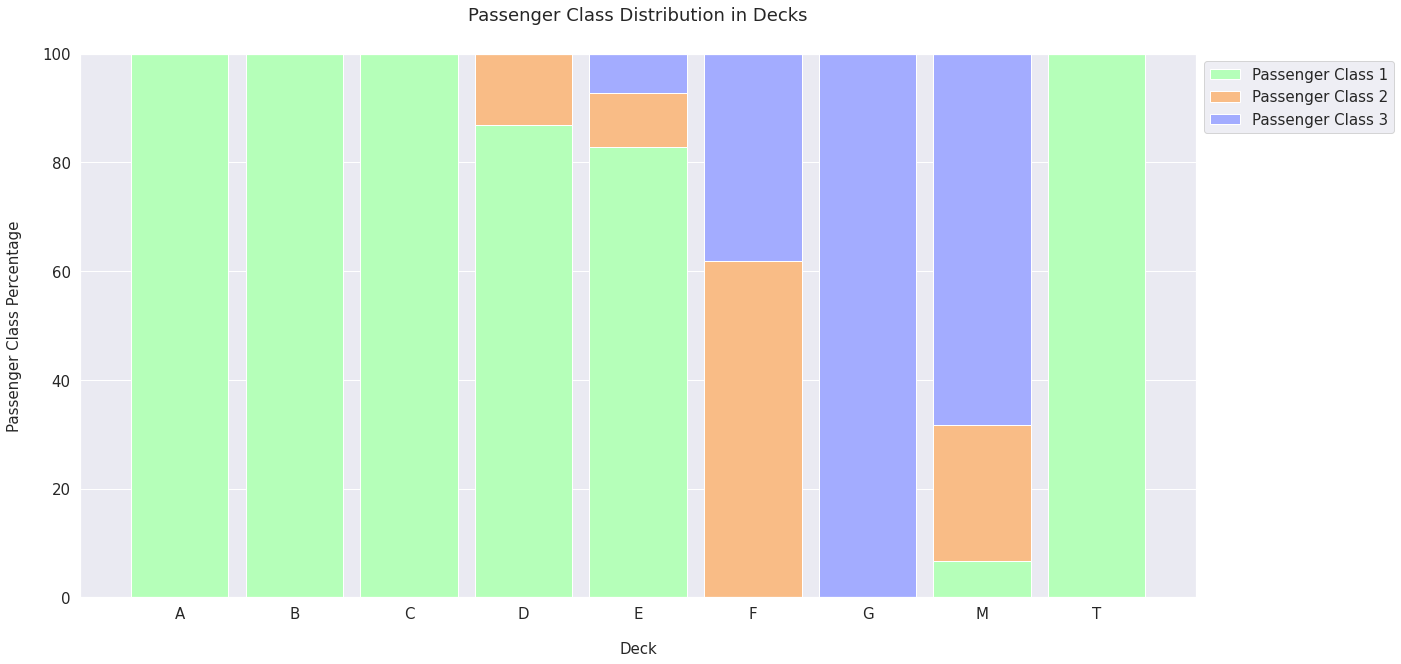

In [18]:
display_pclass_distribution(all_deck_per)

In [19]:
# Passenger in the T deck is changed to A
idx = data_all[data_all["Deck"] == 'T'].index
data_all.loc[idx, "Deck"] = "A"

In [20]:
df_all_decks_survived = data_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 
                                                                                   'Age', 
                                                                                   'SibSp', 
                                                                                   'Parch', 
                                                                                   'Fare', 
                                                                                   'Embarked', 
                                                                                   'Pclass', 
                                                                                   'Cabin', 
                                                                                   'PassengerId', 
                                                                                   'Ticket']).rename(columns={'Name':'Count'}).transpose()
df_all_decks_survived

Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

In [21]:
def get_survived_distribution(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {deck: {} for deck in "ABCDEFGM"}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck, survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    display(df_surv)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_distribution(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_distribution(df_all_decks_survived)
print(all_surv_count)
all_surv_per

,A,B,C,D,E,F,G,M
0,9,12,24,8,8,5,2,481
1,7,35,35,25,24,8,2,206


{'A': {0: 9, 1: 7}, 'B': {0: 12, 1: 35}, 'C': {0: 24, 1: 35}, 'D': {0: 8, 1: 25}, 'E': {0: 8, 1: 24}, 'F': {0: 5, 1: 8}, 'G': {0: 2, 1: 2}, 'M': {0: 481, 1: 206}}


{'A': [56.25, 43.75],
 'B': [25.53191489361702, 74.46808510638297],
 'C': [40.67796610169492, 59.32203389830508],
 'D': [24.242424242424242, 75.75757575757575],
 'E': [25.0, 75.0],
 'F': [38.46153846153847, 61.53846153846154],
 'G': [50.0, 50.0],
 'M': [70.01455604075691, 29.985443959243085]}

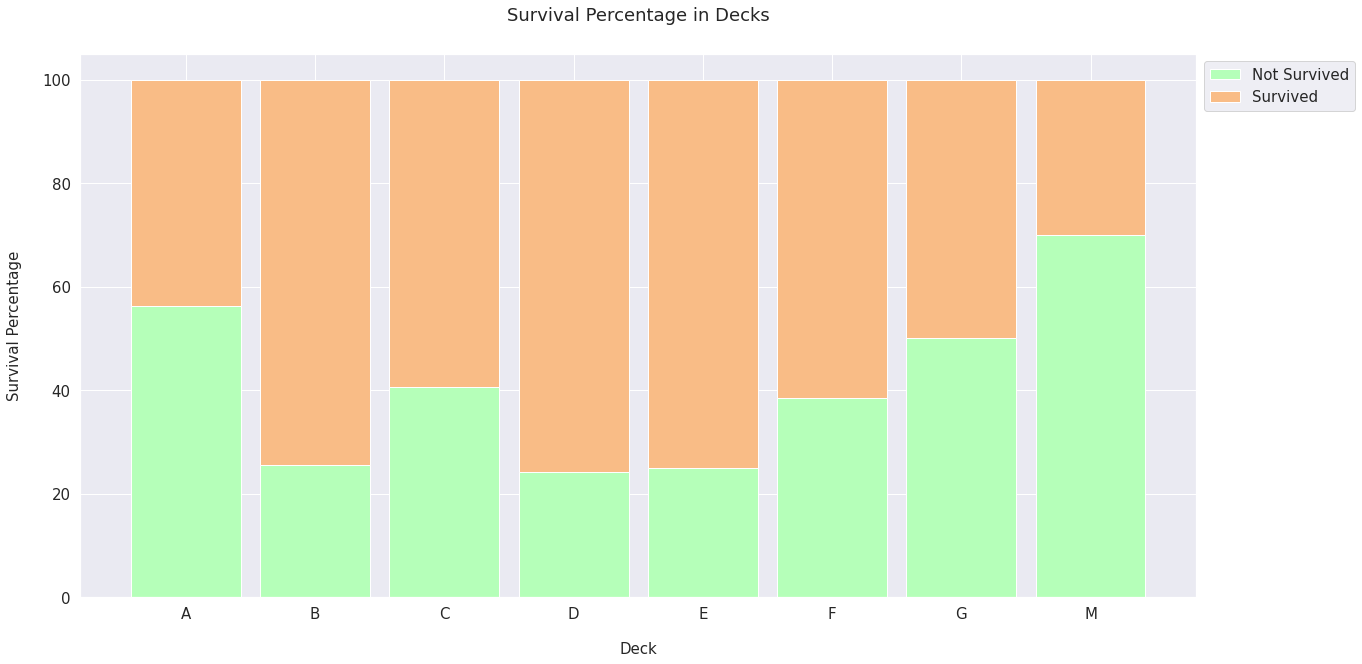

In [22]:
display_surv_distribution(all_surv_per)

* A, B and C decks are labeled as ABC because all of them have only 1st class passengers
* D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
* F and G decks are labeled as FG because of the same reason above
* M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [23]:
data_all['Deck'] = data_all["Deck"].replace(['A', 'B', 'C'], 'ABC')
data_all['Deck'] = data_all["Deck"].replace(['D', 'E'], 'DE')
data_all['Deck'] = data_all["Deck"].replace(['F', 'G'], 'FG')

data_all["Deck"].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [24]:
# Dropping the Cabin feature
data_all.drop(['Cabin'], inplace=True, axis=1)

In [25]:
X, data_test = divide_df(data_all)
dfs = [X, data_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




In [26]:
survived = X["Survived"].value_counts()[1]
not_survived = X["Survived"].value_counts()[0]

survived_percentage = survived / X.shape[0] * 100
not_survived_percentage = not_survived / X.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, X.shape[0], survived_percentage))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, X.shape[0], not_survived_percentage))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


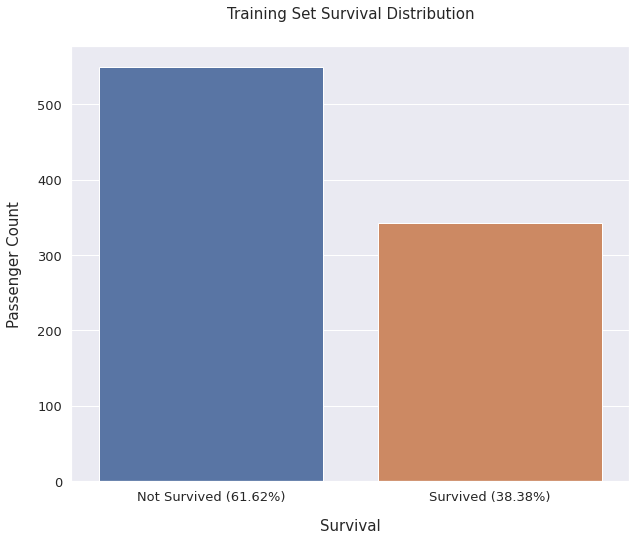

In [27]:
plt.figure(figsize=(10, 8))
sns.countplot(X['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_percentage), 'Survived ({0:.2f}%)'.format(survived_percentage)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [28]:
for i, value in enumerate(X.Age.values):
    if not isinstance(value, float):
        print(i)

In [29]:
X.Age[5]

25.0

In [30]:
X_corr = X.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
X_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
X_corr.drop(X_corr.iloc[1::2].index, inplace=True) # delete duplicates but with swapped rows
X_corr_nd = X_corr.drop(X_corr[X_corr['Correlation Coefficient'] == 1.0].index)

test_corr = data_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
test_corr.drop(test_corr.iloc[1::2].index, inplace=True)
test_corr_nd = test_corr.drop(test_corr[test_corr['Correlation Coefficient'] == 1.0].index)

In [31]:
# Training set high correlations
corr = X_corr_nd['Correlation Coefficient'] > 0.1
X_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [32]:
corr = test_corr_nd['Correlation Coefficient'] > 0.1
test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


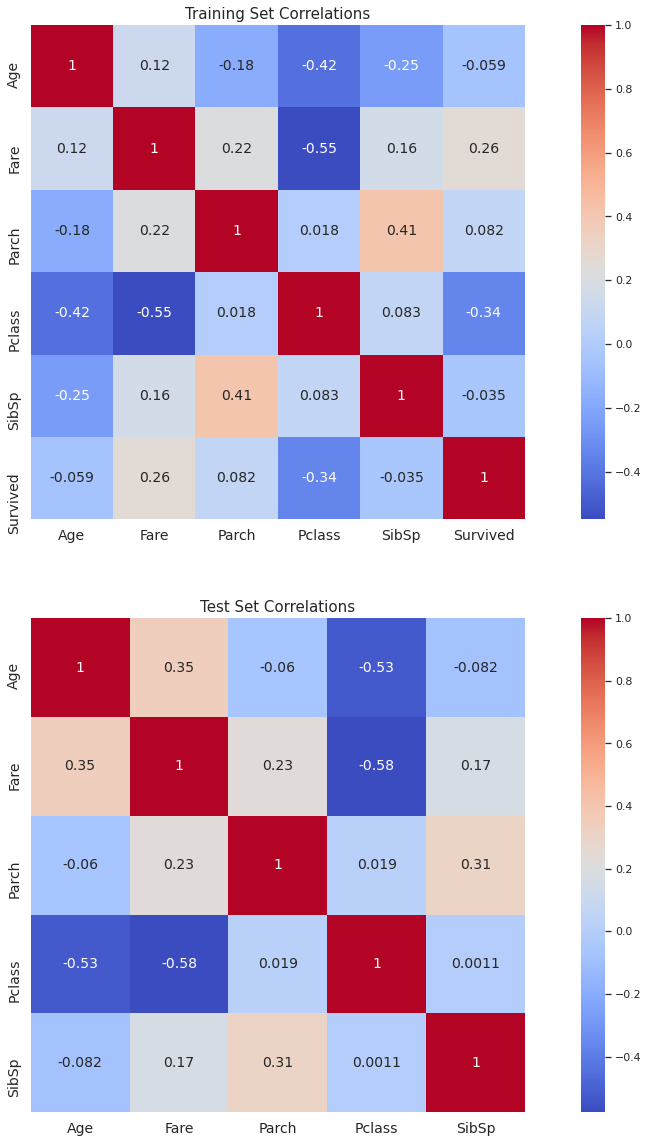

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(X.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(data_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

Both of the continuous features (Age and Fare) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

Distribution of Age feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
In distribution of Fare feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

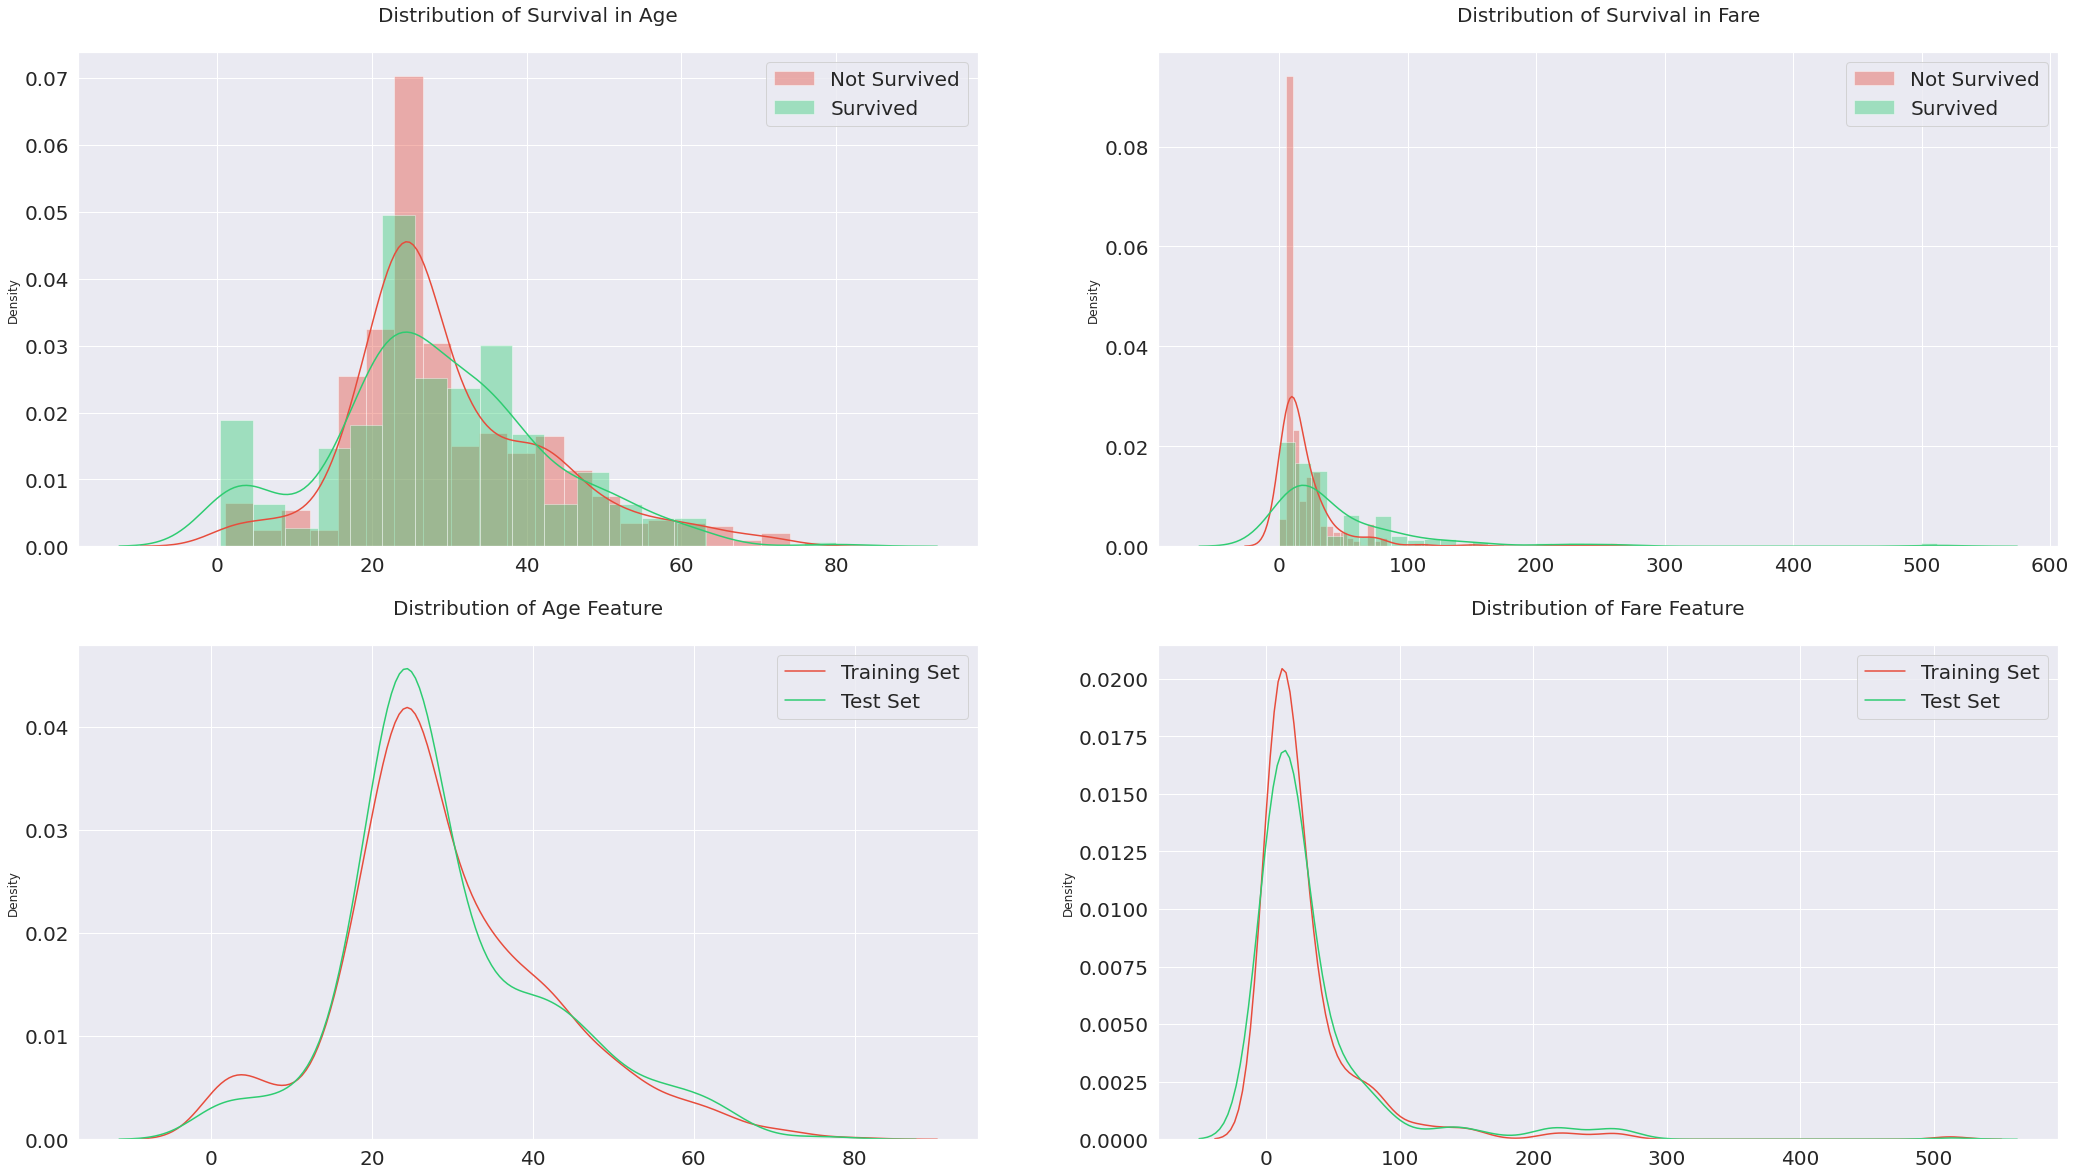

In [34]:
cont_features = ['Age', 'Fare']
surv = X['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(X[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(X[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(X[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(data_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are Pclass and Sex because they have the most homogenous distributions.

Passengers boarded from Southampton has a lower survival rate unlike other ports. More than half of the passengers boarded from Cherbourg had survived. This observation could be related to Pclass feature
Parch and SibSp features show that passengers with only one family member has a higher survival rate

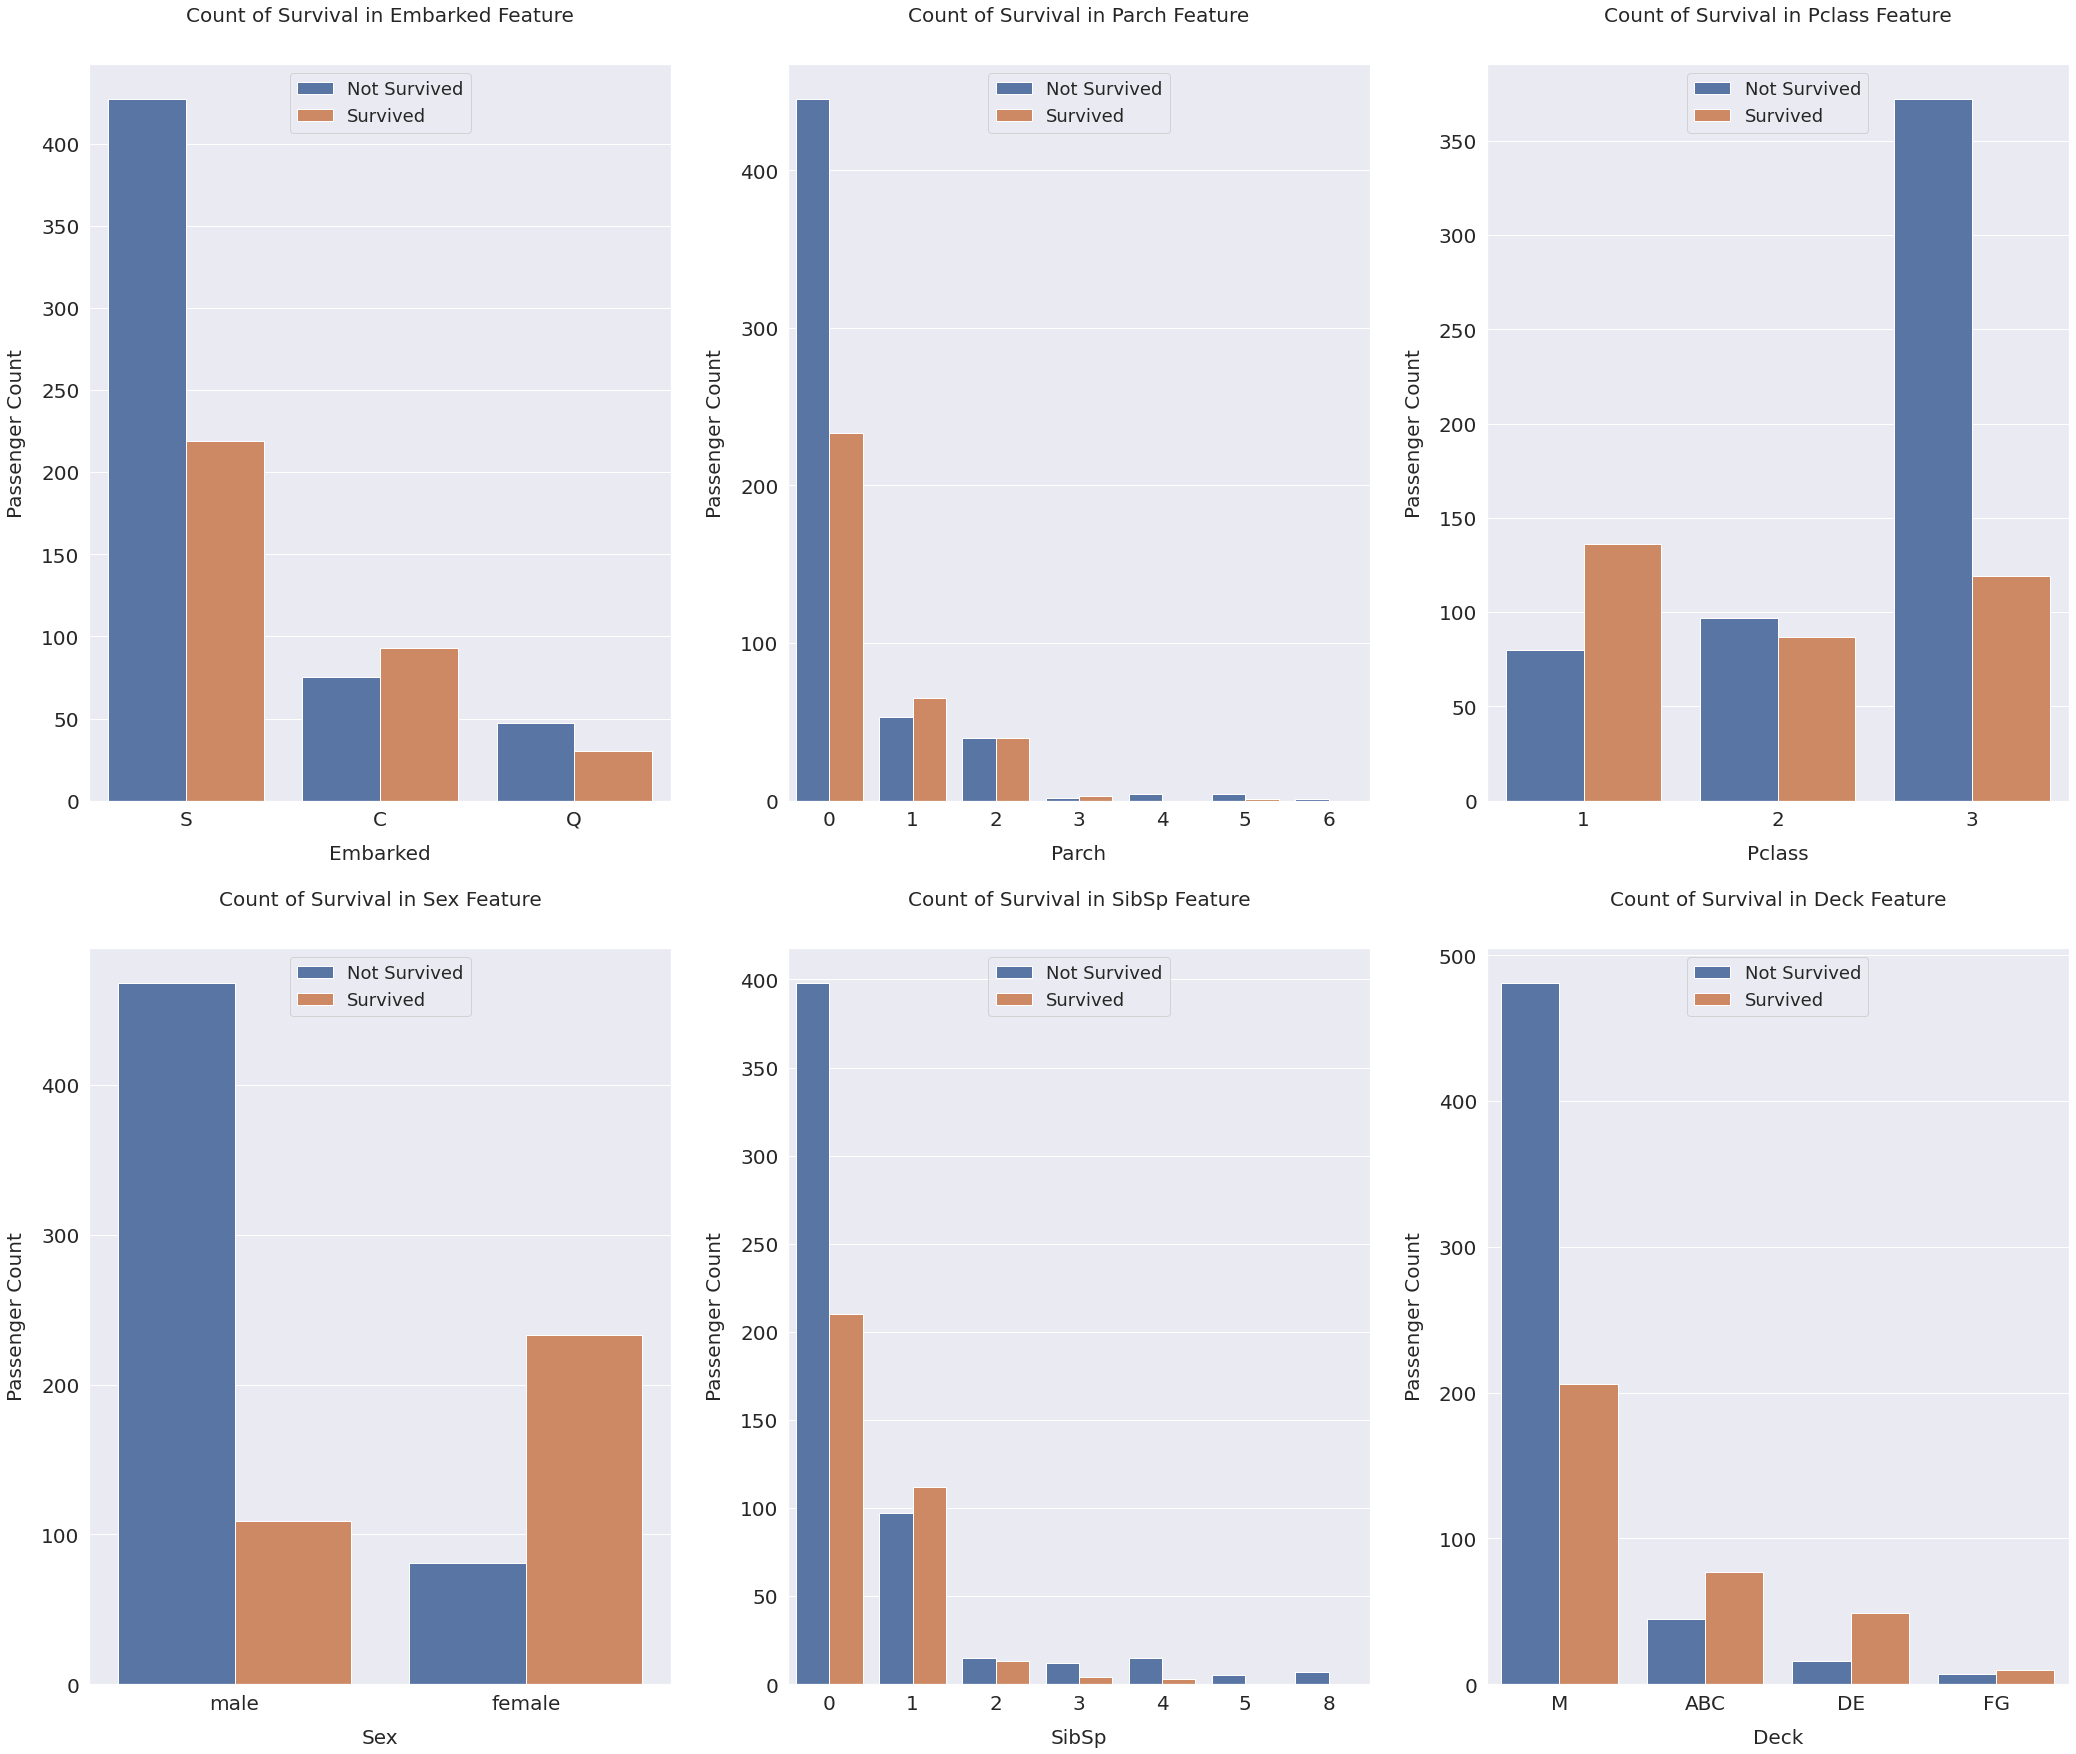

In [35]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=X)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

## Conclusion
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with Survived feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called Deck and dropped Cabin feature at the Exploratory Data Analysis part

# Feature Engineering

In [36]:
df_all = concat_df(X, data_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Binning Continuous Features

In [37]:
df_all['Fare'] = pd.qcut(df_all['Fare'], q=13)

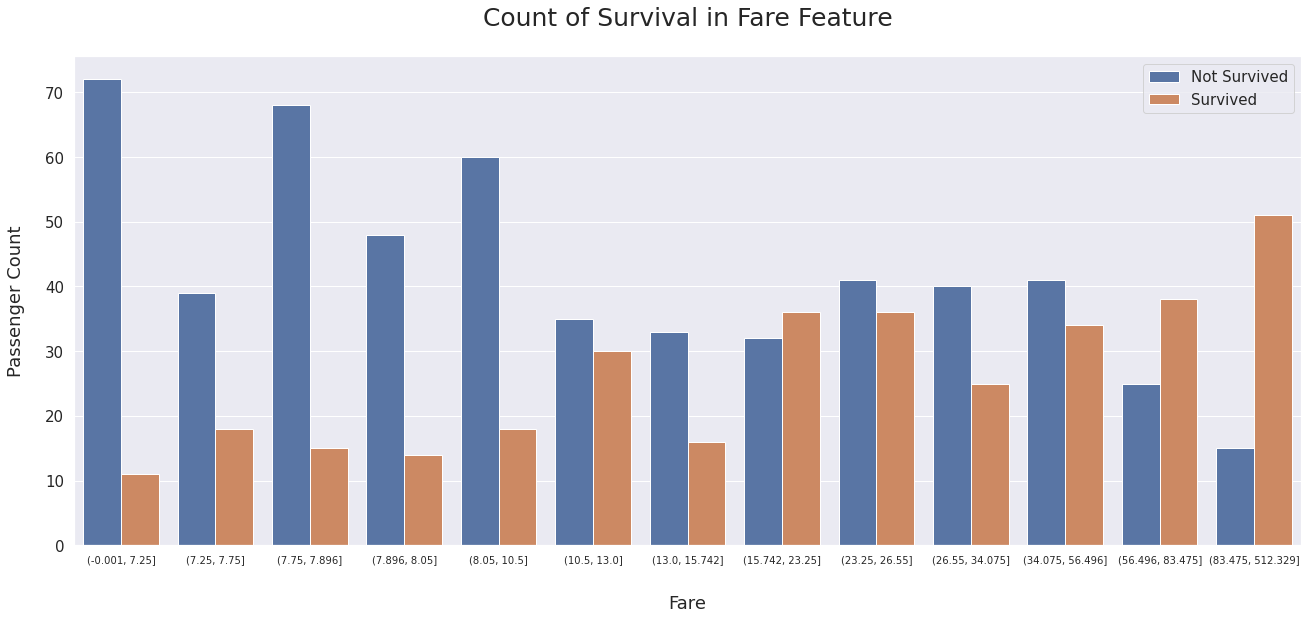

In [38]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=18, labelpad=30)
plt.ylabel('Passenger Count', size=18, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=25, y=1.05)

plt.show()

In [39]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

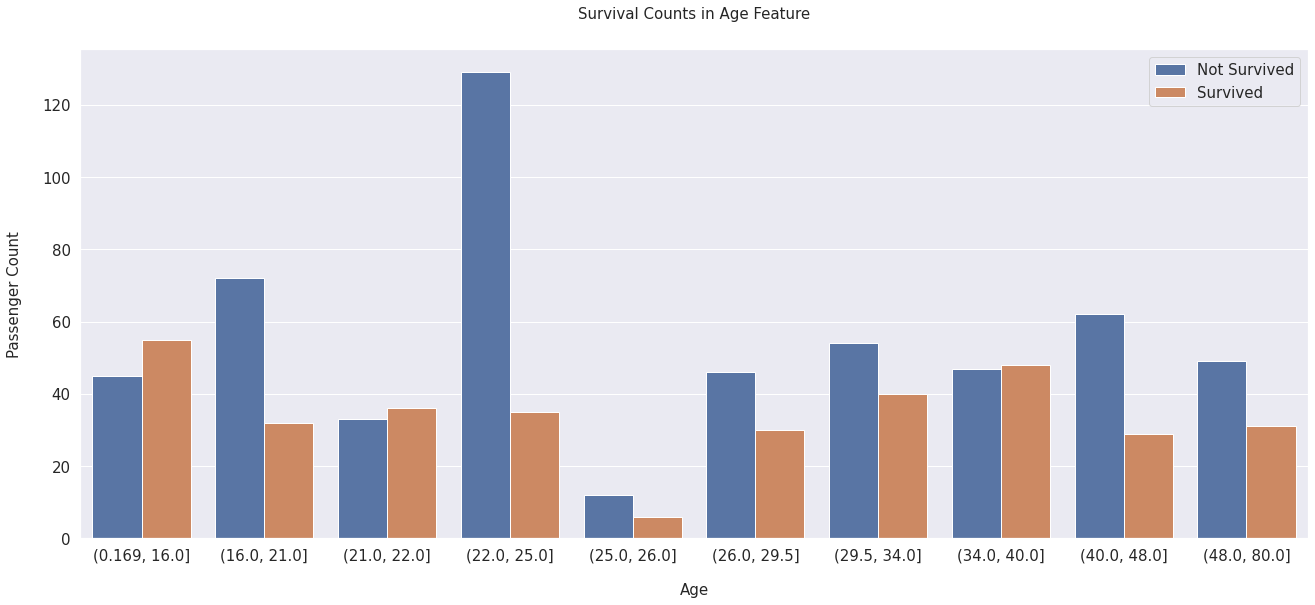

In [40]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

* Family Size with 1 are labeled as Alone
* Family Size with 2, 3 and 4 are labeled as Small
* Family Size with 5 and 6 are labeled as Medium
* Family Size with 7, 8 and 11 are labeled as Large

In [41]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

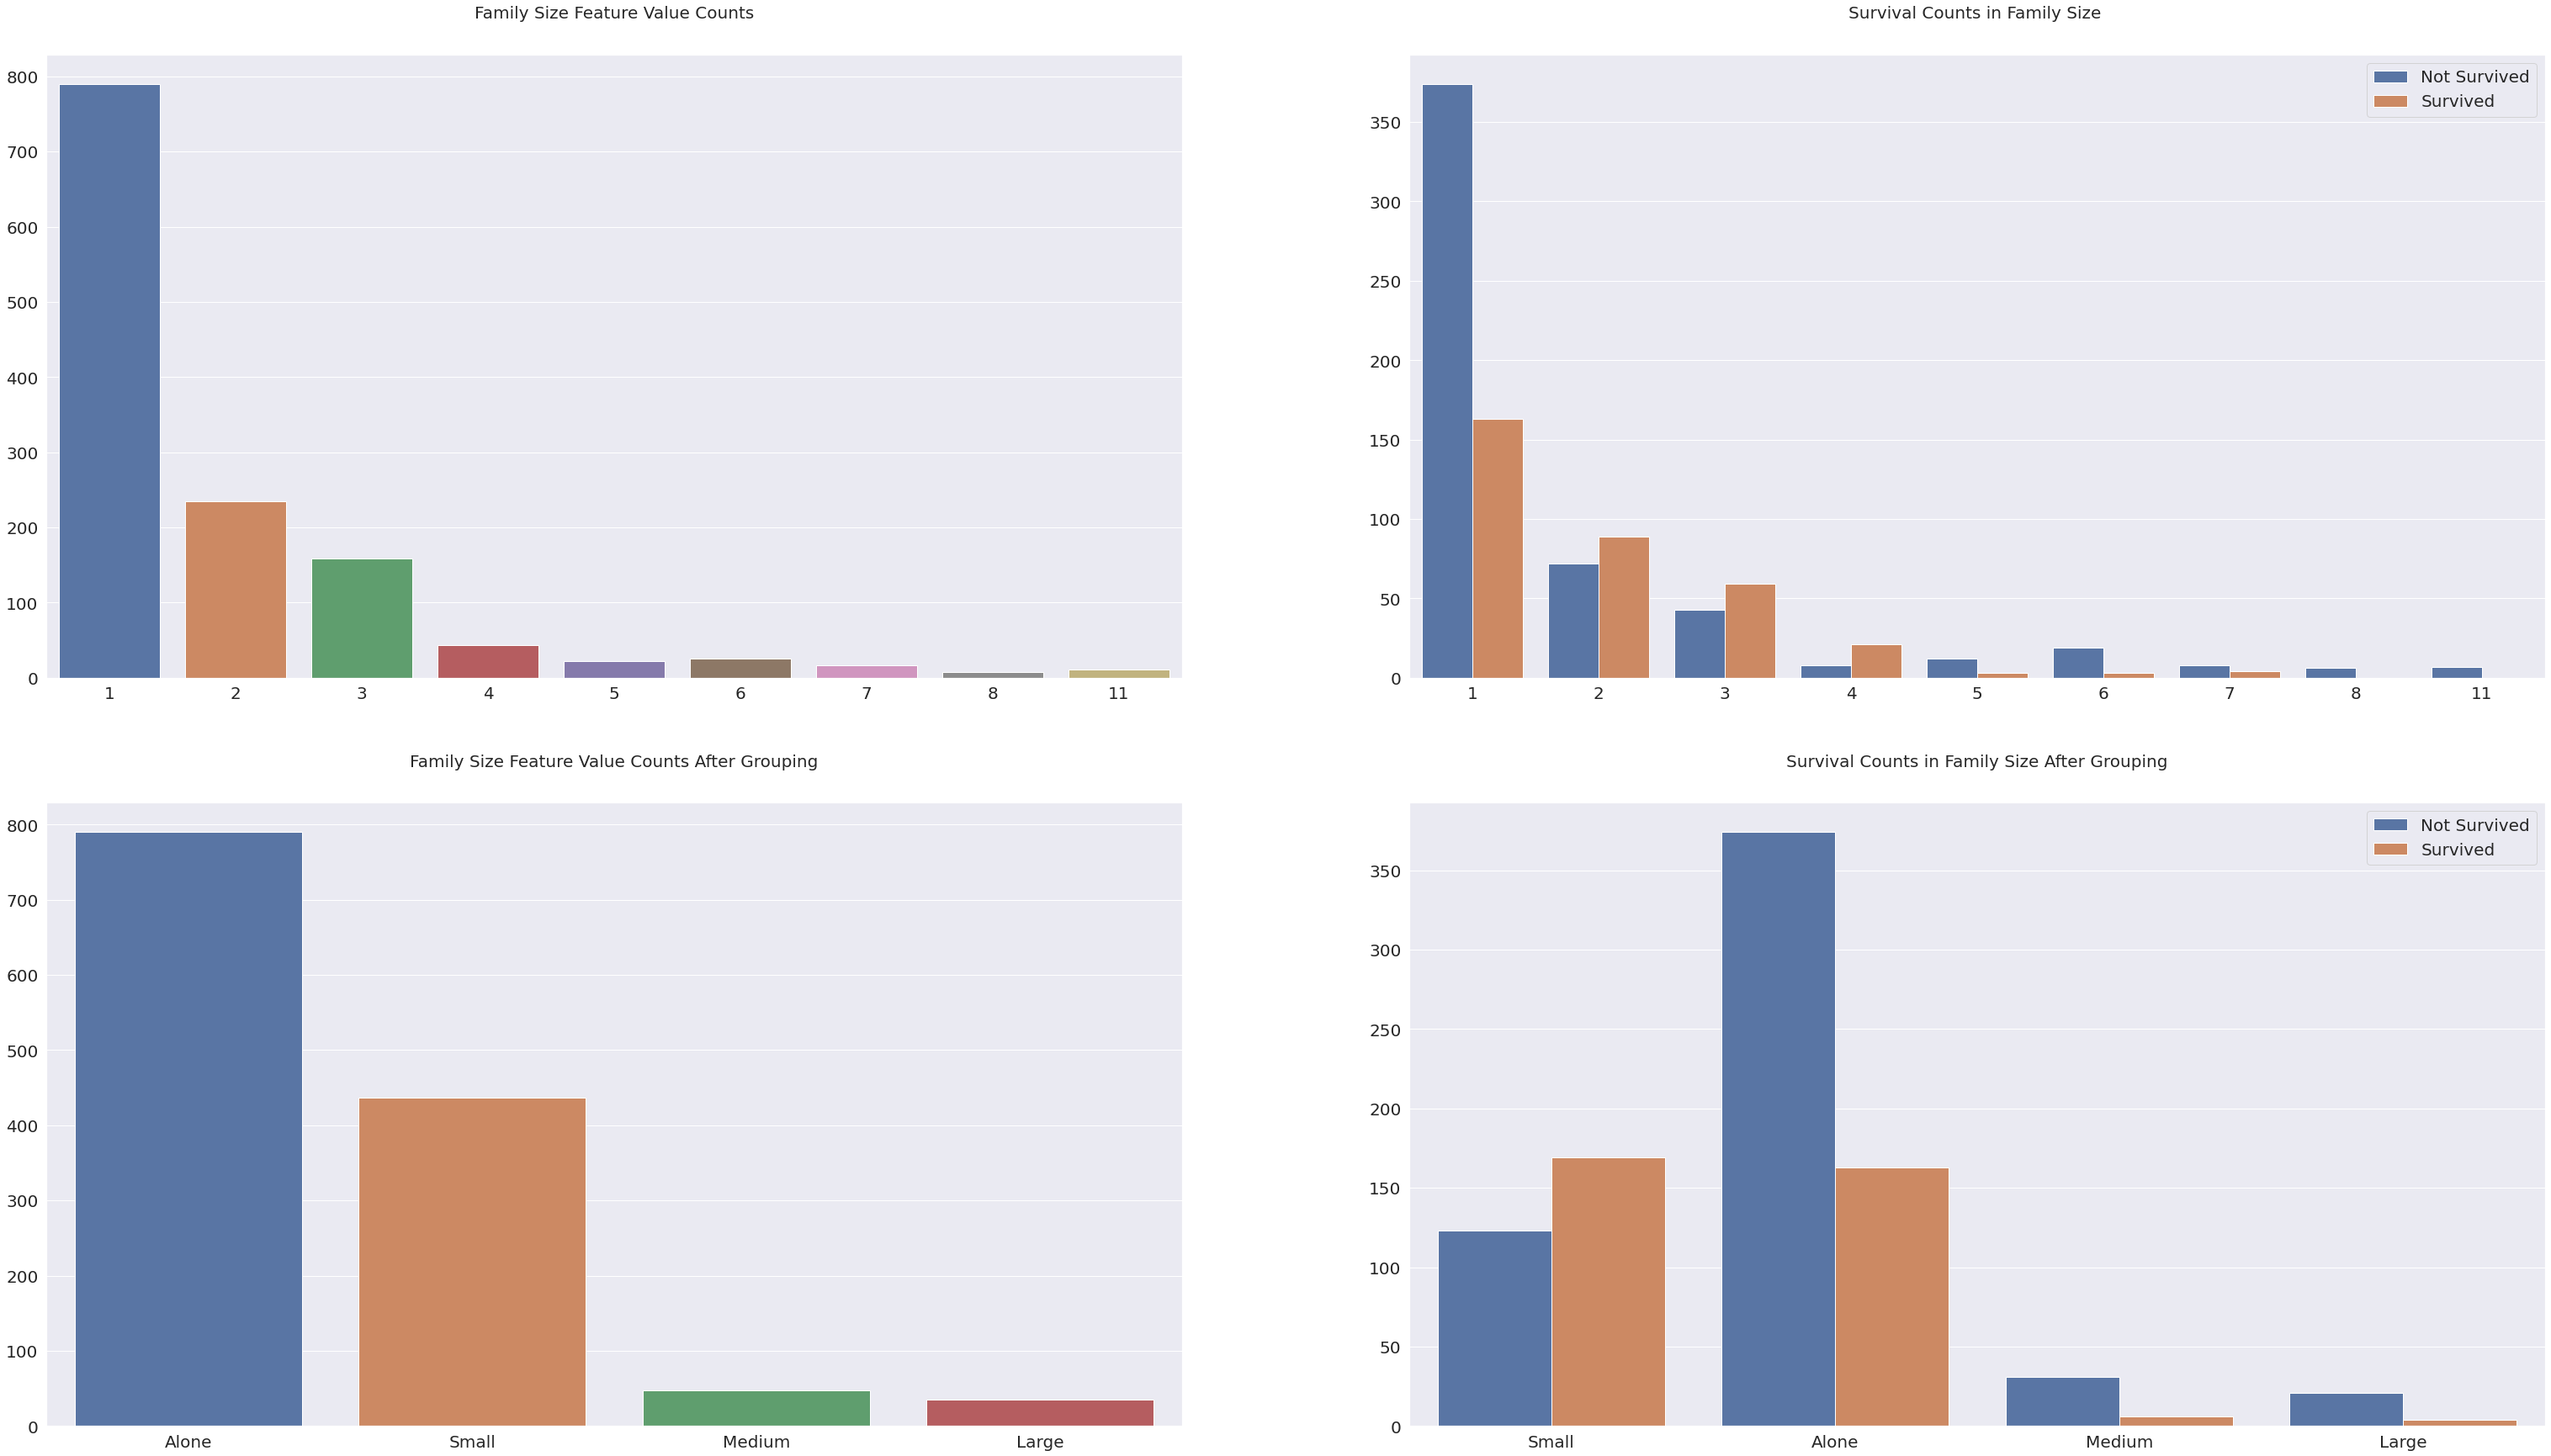

In [42]:
fig, axs = plt.subplots(figsize=(30, 30), ncols=2, nrows=2)

plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

In [43]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')
# return a DataFrame having the same indexes as the original object filled with the transformed values
df_all

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency
0,"(21.0, 22.0]",M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2
2,"(25.0, 26.0]",M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2
4,"(34.0, 40.0]",M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,"(22.0, 25.0]",M,S,"(7.896, 8.05]","Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,1,Alone,1
1305,"(34.0, 40.0]",ABC,C,"(83.475, 512.329]","Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,1,Alone,3
1306,"(34.0, 40.0]",M,S,"(-0.001, 7.25]","Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,1,Alone,1
1307,"(22.0, 25.0]",M,S,"(7.896, 8.05]","Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,1,Alone,1


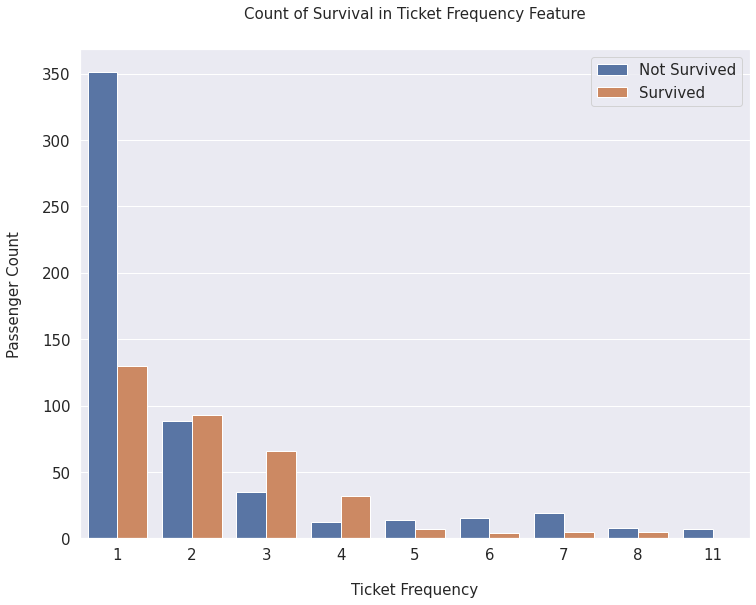

In [44]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

In [45]:
df_all["Title"] = df_all["Name"].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all["Is_Married"] = 0

df_all["Is_Married"].where(df_all["Title"] != "Mrs", 1, inplace=True)
# df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1
display(df_all[["Title", "Is_Married"]])
df_all["Is_Married"].value_counts()

,Title,Is_Married
0,Mr,0
1,Mrs,1
2,Miss,0
3,Mrs,1
4,Mr,0
...,...,...
1304,Mr,0
1305,Dona,0
1306,Mr,0
1307,Mr,0


0    1112
1     197
Name: Is_Married, dtype: int64

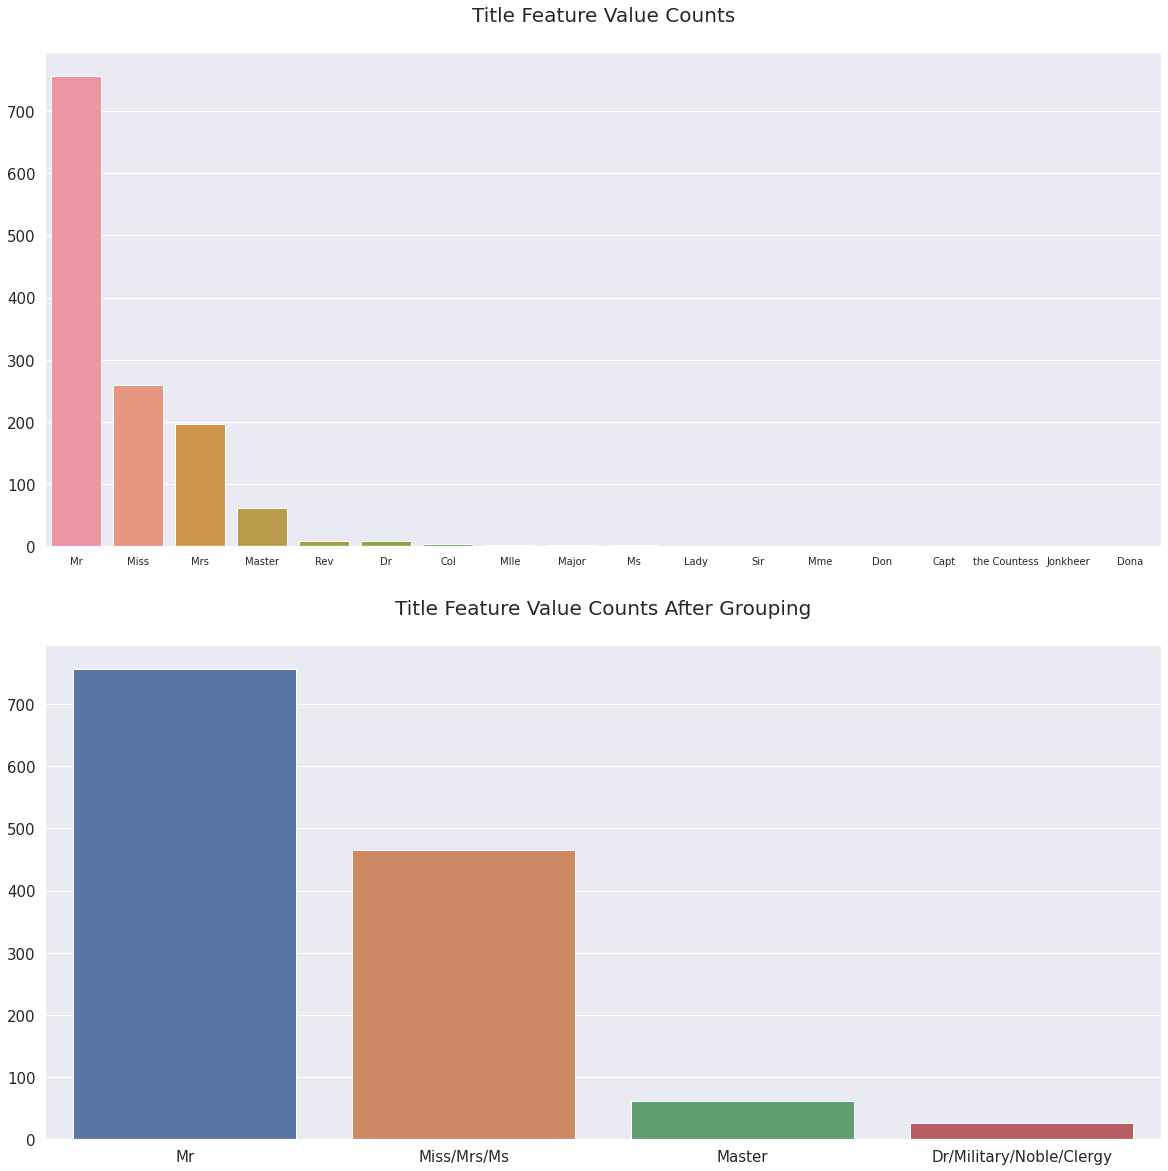

In [46]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### Target Encoding
extract_surname function is used for extracting surnames of passengers from the Name feature. Family feature is created with the extracted surname. This is necessary for grouping passengers in the same family

In [47]:
def extract_surname(data):
    
    families = []
    
    for i in range(len(data)):
        name = data.loc[i]
        
        name_no_bracket = name.split('(')[0] if "(" in name else name
        
        family = name_no_bracket.split(',')[0]
        
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families

In [48]:
df_all["Family"] = extract_surname(df_all["Name"])

In [49]:
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

Family_Survival_Rate is calculated from families in training set since there is no Survived feature in test set. A list of family names that are occuring in both training and test set (non_unique_families), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature.

An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created with the same method. Ticket_Survival_Rate and Family_Survival_Rate are averaged and become Survival_Rate, and Ticket_Survival_Rate_NA and Family_Survival_Rate_NA are also averaged and become Survival_Rate_NA

In [81]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = set(x for x in df_train["Family"].unique() if x in df_test["Family"].unique())
non_unique_tickets = set(x for x in df_train["Ticket"].unique() if x in df_test["Ticket"].unique())

df_family_survival_rate = df_train.groupby("Family")["Survived", "Family", "Family_Size"].median()
df_ticket_sirvival_rate = df_train.groupby("Ticket")["Survived", "Ticket", "Ticket_Frequency"].median()

display(df_family_survival_rate)
display(df_ticket_sirvival_rate)

family_rates = {}
ticket_rates = {}

for family in df_family_survival_rate.index:
    # Checking a family exists in both training and test set, and has members more than 1
    if family in non_unique_families and df_family_survival_rate.loc[family, "Family_Size"] > 1:
        family_rates[family] = df_family_survival_rate.loc[family, "Survived"]

for ticket in df_ticket_sirvival_rate.index:
    # Checking a ticket exists in both training and test set, and has members more than 1
    if ticket in non_unique_tickets and df_ticket_sirvival_rate.loc[ticket, "Ticket_Frequency"] > 1:
        ticket_rates[ticket] = df_ticket_sirvival_rate.loc[ticket, "Survived"]

,Survived,Family_Size
Family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
de Mulder,1.0,1.0
de Pelsmaeker,0.0,1.0
del Carlo,0.0,2.0


,Survived,Ticket_Frequency
Ticket,,
110152,1.0,3.0
110413,1.0,3.0
110465,0.0,2.0
110564,1.0,1.0
110813,1.0,2.0
...,...,...
W./C. 6608,0.0,5.0
W./C. 6609,0.0,1.0
W.E.P. 5734,0.0,2.0


In [94]:
mean_survival_rate = df_train["Survived"].mean()
print(mean_survival_rate)

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train["Family"][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train["Family"][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
    
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)

    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)

df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

0.3838383838383838


In [96]:
for df in (df_train, df_test):
    df["Survival_Rate"] = (df["Ticket_Survival_Rate"] + df["Family_Survival_Rate"]) / 2
    df["Survival_Rate_NA"] = (df["Ticket_Survival_Rate_NA"] + df["Family_Survival_Rate_NA"]) / 2

#### Feature transformation

In [99]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1309 non-null   category
 1   Deck                 1309 non-null   object  
 2   Embarked             1309 non-null   object  
 3   Fare                 1309 non-null   category
 4   Name                 1309 non-null   object  
 5   Parch                1309 non-null   int64   
 6   PassengerId          1309 non-null   int64   
 7   Pclass               1309 non-null   int64   
 8   Sex                  1309 non-null   object  
 9   SibSp                1309 non-null   int64   
 10  Survived             891 non-null    float64 
 11  Ticket               1309 non-null   object  
 12  Family_Size          1309 non-null   int64   
 13  Family_Size_Grouped  1309 non-null   object  
 14  Ticket_Frequency     1309 non-null   int64   
 15  Title                

In [102]:
non_numeric_features = ["Age", "Deck", "Embarked", "Fare", "Sex", "Family_Size_Grouped", "Title"]

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [104]:
df_train.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Frequency,Title,Is_Married,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
0,2,3,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,...,1,3,0,Braund,0.383838,0,0.383838,0,0.383838,0.0
1,7,0,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,2,2,1,Cumings,1.000000,1,1.000000,1,1.000000,1.0
2,4,3,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,...,1,2,0,Heikkinen,0.383838,0,0.383838,0,0.383838,0.0
3,7,0,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,2,2,1,Futrelle,0.383838,0,0.383838,0,0.383838,0.0
4,7,3,2,3,"Allen, Mr. William Henry",0,5,3,1,0,...,1,3,0,Allen,0.383838,0,0.383838,0,0.383838,0.0


In [105]:
categorical_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in categorical_features:
        encoded_feat = OneHotEncoder(sparse=False).fit_transform(df[feature].values.reshape(-1, 1))
        n = df[feature].nunique()
        cols = [f"{feature}_{j}" for j in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

Age and Fare features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. Family_Size is created by adding Parch and SibSp features and 1. Ticket_Frequency is created by counting the occurence of Ticket values.

Name feature is very useful. First, Title and Is_Married features are created from the title prefix in the names. Second, Family_Survival_Rate and Family_Survival_Rate_NA features are created by target encoding the surname of the passengers. Ticket_Survival_Rate is created by target encoding the Ticket feature. Survival_Rate feature is created by averaging the Family_Survival_Rate and Ticket_Survival_Rate features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created 5 new features (Family_Size, Title, Is_Married, Survival_Rate and Survival_Rate_NA) and dropped the useless features after encoding.

In [112]:
df_all = concat_df(df_train, df_test)

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [113]:
df_all.columns

Index(['Age', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4', 'Embarked_1',
       'Embarked_2', 'Embarked_3', 'Family_Size_Grouped_1',
       'Family_Size_Grouped_2', 'Family_Size_Grouped_3',
       'Family_Size_Grouped_4', 'Fare', 'Is_Married', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_1', 'Sex_2', 'Survival_Rate', 'Survival_Rate_NA',
       'Ticket_Frequency', 'Title_1', 'Title_2', 'Title_3', 'Title_4'],
      dtype='object')

# Model


In [118]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train["Survived"].values

X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

for name, df in zip(("X_train", "y_train", "X_test"), (X_train, y_train, X_test)):
    print(f"{name} shape: {df.shape}")

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [120]:
single_best_model = RandomForestClassifier(criterion="gini",
                                          n_estimators=1100,
                                          max_depth=5,
                                          min_samples_leaf=5,
                                          min_samples_split=4,
                                          max_features="auto",
                                          oob_score=True,
                                          random_state=SEED,
                                          n_jobs=-1,
                                          verbose=1)

leaderboard_model = RandomForestClassifier(criterion="gini",
                                          n_estimators=1750,
                                          max_depth=7,
                                          min_samples_split=6,
                                          min_samples_leaf=6,
                                          max_features="auto",
                                          oob_score=True,
                                          random_state=SEED,
                                          n_jobs=-1,
                                          verbose=1)

In [121]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), 
                     columns=["{}_{}".format(i, j) for i in range(1, N + 1) for j in range(2)])
probs

,1_0,1_1,2_0,2_1,3_0,3_1,4_0,4_1,5_0,5_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), 
                           columns=["Fold_{}".format(i) for i in range(1, N + 1)],
                          index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=SEED, shuffle=True)

In [125]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"Fold {fold}\n")
    
    # Fitting the model
    leaderboard_model.fit(X_train[train_idx], y_train[train_idx])
    
    # Computing Train AUC score
    train_false_pos_rate, train_true_pos_rate, train_thresholds = roc_curve(
        y_train[train_idx],
        leaderboard_model.predict_proba(X_train[train_idx])[:, 1]
    )
    train_auc_score = auc(train_false_pos_rate, train_true_pos_rate)
    
    # Computing Validation AUC score
    val_false_pos_rate, val_true_pos_rate, val_thresholds = roc_curve(
        y_train[val_idx],
        leaderboard_model.predict_proba(X_train[val_idx])[:, 1]
    )
    val_auc_score = auc(val_false_pos_rate, val_true_pos_rate)
    
    scores.append((train_auc_score, val_auc_score))
    
    fprs.append(val_false_pos_rate)
    tprs.append(val_true_pos_rate)
    
    # X_test probabilities
    probs.loc[:, f"Fold_{fold}_Prob_0"] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, f'Fold_{fold}_Prob_1'] = leaderboard_model.predict_proba(X_test)[:, 1]
    
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
    
    oob += leaderboard_model.oob_score_ / N
    
    print(f"Fold {fold} OOB score: {leaderboard_model.oob_score_}\n")
else:
    print(f"Average OO score: {oob}\n -------------------Finished!-------------------")

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 1 OOB score: 0.8342696629213483

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2 OOB score: 0.8485273492286115

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3 OOB score: 0.8485273492286115

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4 OOB score: 0.8429172510518934

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5 OOB score: 0.8387096774193549

Average OO score: 0.8425902579699639


## Feature importance

In [130]:
importances["Mean_Importance"] = importances.mean(axis=1)
importances.sort_values(kind='quicksort', by="Mean_Importance", inplace=True, ascending=False)
importances

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Mean_Importance
Ticket_Frequency,0.144994,0.126246,0.147239,0.132734,0.145016,0.139246
Deck_4,0.140375,0.139599,0.135961,0.125267,0.126443,0.133529
Family_Size_Grouped_3,0.120312,0.135801,0.123374,0.133290,0.119754,0.126506
Family_Size_Grouped_2,0.120645,0.127419,0.123313,0.132998,0.114970,0.123869
Survival_Rate_NA,0.118087,0.112967,0.101996,0.111331,0.099778,0.108832
Family_Size_Grouped_1,0.057871,0.053968,0.056900,0.043280,0.055895,0.053583
Deck_1,0.044466,0.043876,0.048055,0.047238,0.052036,0.047134
Deck_2,0.036911,0.039702,0.037698,0.035074,0.042701,0.038417
Pclass_1,0.031678,0.029995,0.039879,0.039104,0.040500,0.036231
Age,0.028715,0.026572,0.031380,0.031727,0.031907,0.030060


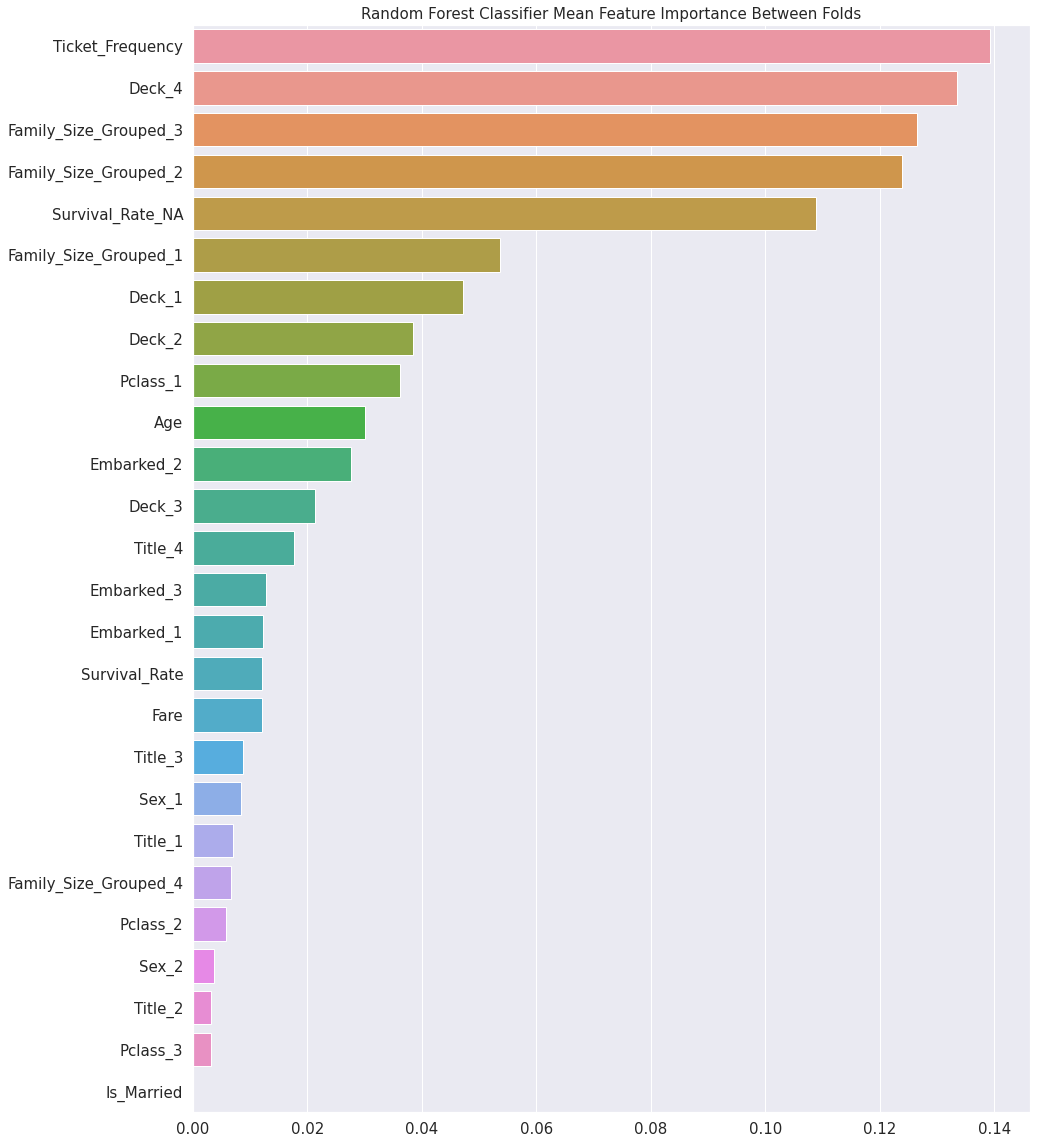

In [139]:
plt.figure(figsize=(15, 20))
sns.barplot(x="Mean_Importance", y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)
plt.show()

### ROC curve

In [140]:
def plot_ROC_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC Fold {i} (AUC = {roc_auc:.3f})")
    
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})', lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

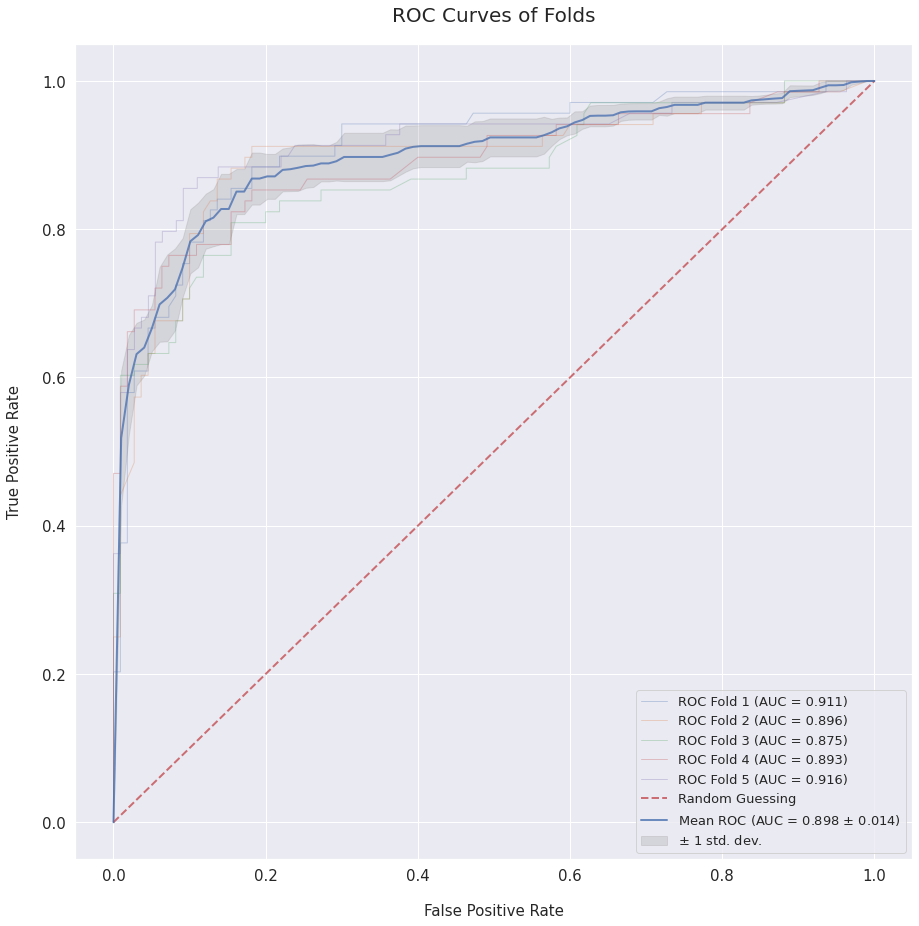

In [142]:
plot_ROC_curve(fprs, tprs)

### Submission

In [144]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
class_survived

['Fold_1_Prob_1',
 'Fold_2_Prob_1',
 'Fold_3_Prob_1',
 'Fold_4_Prob_1',
 'Fold_5_Prob_1']

In [154]:
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0


In [160]:
probs[['0', '1', 'pred']]


,0,1,pred
0,1.106596,0.097296,0
1,0.699085,0.521786,1
2,1.091414,0.113110,0
3,1.069258,0.136190,0
4,0.458512,0.772384,1
...,...,...,...
413,1.102273,0.101799,0
414,0.283777,0.954399,1
415,1.111674,0.092006,0
416,1.102273,0.101799,0


In [161]:
pos = probs[probs["1"] >= 0.5].index
probs.loc[pos, "pred"] = 1
y_pred = probs["pred"].astype(int)

In [165]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df["PassengerId"] = df_test["PassengerId"]
submission_df["Survived"] = y_pred.values
submission_df

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [166]:
submission_df.to_csv("submissions.csv", header=True, index=False)